<center><h1>Music recommendation using graphs</h1>
<h2>MLNS PROJECT</h2>
<h3>Coded by Chloé Daems, Amir Mahmoudi and Anne-Claire Laisney</h3>
</center>

This is the main notebook to create a benchmark of graph based music recommendation systems inspired by the *Katarya, R., Verma, O.P. Efficient music recommender system using context graph and particle swarm. Multimed Tools Appl 77, 2673–2687 (2018).* [paper](URL 'https://link.springer.com/article/10.1007/s11042-017-4447-x'), using data from the user.getRecentTracks of the [Last.fm](URL 'https://www.last.fm/api/show/user.getRecentTracks') API.

In [1]:
#Import the libraries
from os.path import exists
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.sparse import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

from IPython.display import clear_output

from utils.dataframe_utils import *
from utils.graph_utils import *

## Create the graph

**Get the dataset**

In [2]:
user_id_profile = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', sep = '\t')
user_id_logs = users('lastfm-dataset-1K/user_id_logs_v2.tsv')

/usr/local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
user_id_profile.head()

,#id,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [4]:
user_id_logs.head()

,userid,timestamp,artist-id,artist-name,track-id,track-name
0,user_000001,2009-05-04 23:08:57,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,7369ec4f-b377-5683-86bd-f02897317103,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04 13:54:10,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,8a0799b1-2f64-5e7b-9436-2228c9d65637,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04 13:52:04,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,44da66dc-6a34-54de-a4d9-686bc38ede0f,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04 13:42:52,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,e625acbe-1360-528d-8afe-4ad88424e0c0,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04 13:42:11,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,fa332ed7-b701-5669-9e8e-0961658cdb43,Mc1 (Live_2009_4_15)


**We create a train and test set**

In the test set, we would have only the 2 last month of listening for each users.

In [5]:
try:
    test_user_id_logs = user_id_logs[user_id_logs['timestamp'] > datetime.datetime(2009, 3, 4).replace(tzinfo=datetime.timezone.utc)]
    train_user_id_logs = user_id_logs[user_id_logs['timestamp'] < datetime.datetime(2009, 3, 4).replace(tzinfo=datetime.timezone.utc)]
except:
    test_user_id_logs = user_id_logs[user_id_logs['timestamp'] > datetime.datetime(2009, 3, 4)]
    train_user_id_logs = user_id_logs[user_id_logs['timestamp'] < datetime.datetime(2009, 3, 4)]

try:
    val_user_id_logs = train_user_id_logs[train_user_id_logs['timestamp'] > datetime.datetime(2009, 1, 4).replace(tzinfo=datetime.timezone.utc)]
    train_user_id_logs = train_user_id_logs[train_user_id_logs['timestamp'] < datetime.datetime(2009, 1, 4).replace(tzinfo=datetime.timezone.utc)]
except:
    val_user_id_logs = train_user_id_logs[train_user_id_logs['timestamp'] > datetime.datetime(2009, 1, 4)]
    train_user_id_logs = train_user_id_logs[train_user_id_logs['timestamp'] < datetime.datetime(2009, 1, 4)]

In [6]:
print(f'train shape : ({train_user_id_logs.shape}, val shape : ({val_user_id_logs.shape}) and test shape : ({test_user_id_logs.shape})')

train shape : ((7975441, 6), val shape : ((544126, 6)) and test shape : ((613400, 6))


**Let's only take the n most listened songs of each users**

In [7]:
if not exists('./saved_data/train_user_top_logs.tsv'):
    train_user_top_logs = get_only_top(train_user_id_logs,user_id_profile['#id'], n_top = 50)
    train_user_top_logs = train_user_top_logs.nlargest(10000,'count')
    train_user_top_logs.to_csv('./saved_data/train_user_top_logs.tsv')

else : 
    train_user_top_logs = pd.read_csv('./saved_data/train_user_top_logs.tsv', index_col=0)

train_user_top_logs.head()

,track-name,artist-name,userid,artist-id,track-id,count
43661,Jolene,Cake,user_000949,fa7b9055-3703-473a-8a09-adf2fe031a24,60f0bfa4-8da9-4840-b5fe-23c1fc470f34,1456.0
43662,Staring At The Sun,Tv On The Radio,user_000949,eb872766-98f6-453d-883f-2ae908a18315,64581a21-566d-4b24-99ae-c5f48b75e660,1409.0
6809,Wings Of Words,Chemistry,user_000141,c8524763-e7d7-4225-8a9a-e7b64db5a1e2,2caf09d4-aad9-5f2d-b66d-616f2c2d0e35,1365.0
43663,Heartbeats,The Knife,user_000949,bf710b71-48e5-4e15-9bd6-96debb2e4e98,db4c9220-df76-4b42-b6f5-8bf52cc80f77,1362.0
43664,Anthems For A Seventeen Year Old Girl,Broken Social Scene,user_000949,2eada8f8-056a-4093-bbc2-004909ce743b,91951530-d978-4648-95b1-08b1f49ffba5,1352.0


**Transform the dataset into a bipartite graph**

In [10]:
#Get all the artists and music dfs
track_df, artist_df = bipartite_graph('./saved_data/track_df.tsv','./saved_data/artists_df.tsv',train_user_top_logs)

In [11]:
track_df.head()

,track-name,artist-name,artist-id,track-id
0,Music,Cornelius,df765d93-621c-437f-99fe-fda9e135f89a,52bef5e2-17b6-5742-b846-09a6b750e857
1,Gum,Cornelius,df765d93-621c-437f-99fe-fda9e135f89a,bb9a7981-016d-596e-b17f-ba07a346d2d4
2,Mario Basanov & Vidis ‘Test’,Gilles Peterson,4c4e3121-4d12-4f7a-a77c-5becd849fb3c,7434fb0f-1245-5a58-b343-cca4d0e2c107
3,Child Song,The Cinematic Orchestra,7c158ea8-c0aa-410e-bdc1-20bba9759577,4562ff4f-b619-5557-8600-87f6d0d9f348
4,To Build A Home,The Cinematic Orchestra,7c158ea8-c0aa-410e-bdc1-20bba9759577,dcf825de-85a9-5b53-9d2b-a9d574b57470


In [12]:
artist_df.head()

,artist-name,artist-id
0,Cornelius,df765d93-621c-437f-99fe-fda9e135f89a
1,Gilles Peterson,4c4e3121-4d12-4f7a-a77c-5becd849fb3c
2,The Cinematic Orchestra,7c158ea8-c0aa-410e-bdc1-20bba9759577
3,Radiohead,a74b1b7f-71a5-4011-9441-d0b5e4122711
4,A Hundred Birds,f5341587-6c20-4e0f-bdfd-62b2122825f2


We create the train graph

In [15]:
G = graph_generator(train_user_top_logs,train_user_top_logs,user_id_profile,track_df,artist_df)
nx.write_gml(G, "saved_data/graph_user_tracks_train.gml")


**Now we transform the validation data set in a bipartite graph**

In [18]:
#We transform the val set into a bipartite graph

#First we select only the music tracks that are in the train set
val_user_id_logs = val_user_id_logs[val_user_id_logs['track-id'].isin(track_df['track-id'])]
val_user_top_logs = get_only_top(val_user_id_logs,user_id_profile['#id'], n_top = -1)

Just finished for user_001000


In [19]:
#Then we create the graph
G_val = graph_generator(val_user_top_logs,train_user_top_logs,user_id_profile,track_df,artist_df)
#save the graph
nx.write_gml(G_val, "saved_data/graph_user_tracks_val.gml")

In [20]:
#We transform the test set into a bipartite graph

#First we select only the music tracks that are in the train set
test_user_id_logs = test_user_id_logs[test_user_id_logs['track-id'].isin(track_df['track-id'])]
test_user_top_logs = get_only_top(test_user_id_logs,user_id_profile['#id'], n_top = -1)

Just finished for user_001000


In [21]:
#Then we create the graph
G_test_gt = graph_generator(test_user_top_logs,train_user_top_logs,user_id_profile,track_df,artist_df)
#save the graph
nx.write_gml(G_test_gt, "saved_data/graph_user_tracks_test_groundtruth.gml")

In [22]:
# We concat the train and val set to create a new X to predict the test set new links
#Concatenate the train and val sets summing the count for the same track and the same user
train_val_user_top_logs = pd.concat([train_user_top_logs, val_user_top_logs], ignore_index=True)
#sum count column for same track and same user
train_val_user_top_logs.head()

,track-name,artist-name,userid,artist-id,track-id,count
0,Jolene,Cake,user_000949,fa7b9055-3703-473a-8a09-adf2fe031a24,60f0bfa4-8da9-4840-b5fe-23c1fc470f34,1456.0
1,Staring At The Sun,Tv On The Radio,user_000949,eb872766-98f6-453d-883f-2ae908a18315,64581a21-566d-4b24-99ae-c5f48b75e660,1409.0
2,Wings Of Words,Chemistry,user_000141,c8524763-e7d7-4225-8a9a-e7b64db5a1e2,2caf09d4-aad9-5f2d-b66d-616f2c2d0e35,1365.0
3,Heartbeats,The Knife,user_000949,bf710b71-48e5-4e15-9bd6-96debb2e4e98,db4c9220-df76-4b42-b6f5-8bf52cc80f77,1362.0
4,Anthems For A Seventeen Year Old Girl,Broken Social Scene,user_000949,2eada8f8-056a-4093-bbc2-004909ce743b,91951530-d978-4648-95b1-08b1f49ffba5,1352.0


In [24]:
#Then we create the graph
G_test = graph_generator(train_val_user_top_logs,train_user_top_logs,user_id_profile,track_df,artist_df)
nx.write_gml(G_test, "saved_data/graph_user_tracks_train+val.gml")

## Create the models

**Get the graph**

In [2]:
train_G  = nx.read_gml("saved_data/graph_user_tracks_train.gml")
val_G  = nx.read_gml("saved_data/graph_user_tracks_val.gml")
G_test = nx.read_gml("saved_data/graph_user_tracks_train+val.gml")
G_test_gt = nx.read_gml("saved_data/graph_user_tracks_test_groundtruth.gml")

**Modify the graph the reduce the number of links to predict**

In [3]:
G_test, train_G,val_G, G_test_gt = remove_low_degree_nodes(G_test,train_G,val_G, G_test_gt)
len(G_test.nodes),len(train_G.nodes),len(val_G.nodes), len(G_test_gt.nodes)

(9359, 9359, 9359, 9359)

In [4]:
G_test, train_G,val_G,G_test_gt = remove_low_artists(G_test,train_G,val_G, G_test_gt)
len(G_test.nodes),len(train_G.nodes),len(val_G.nodes), len(G_test_gt.nodes)

(686, 686, 686, 686)

#### Unsupervised link prediction

In [5]:
def preferential_attachement(graph, edges=train_G.edges()):
    PA = {}
    
    for edge in edges:
        PA[edge] = graph.degree(edge[0]) * graph.degree(edge[1])
        
    return PA
    
pa = preferential_attachement(train_G)

In [6]:
def Jaccard(graph, edges=train_G.edges()):
    Jaccard = {}
    # Compute Jaccard metric for each non_edge of the graph
    
    for edge in edges: 
        inter_size = len(list(nx.common_neighbors(graph, edge[0], edge[1])))
        union_size = len(set(graph[edge[0]]) | set(graph[edge[1]]))

        if union_size != 0:
            Jaccard[edge] = inter_size / union_size
        else : 
            Jaccard[edge] = 0

    
    return Jaccard

In [7]:
def AdamicAdar(graph, edges=train_G.edges()):
    AdamicAdar = {}
    
    for edge in edges: 
        inter_list = nx.common_neighbors(graph, edge[0], edge[1])
        AdamicAdar[edge] = sum( [1/np.log(graph.degree(node)) for node in inter_list] )
    
    return AdamicAdar

In [8]:
def predict_edges(metric, k):
    
    # Shuffle randomly entries of dictionnary 
    l = list(metric.items())
    np.random.seed(10) # fix random seed to obtain same random shuffling when repeating experiment
    np.random.shuffle(l)
    metric = dict(l)

    # Retrieve top k value 
    metric = dict(sorted(metric.items(), key=lambda x:x[1], reverse=True)[:k])
    print(metric.items())

predict_edges(pa, 10)

dict_items([(('user_000787', '0e938086-1f83-5242-944b-7315de233b57'), 198), (('user_000610', '487023bc-e43f-5739-b62d-d634b0e12346'), 154), (('user_000610', '587e8902-dd97-5f4b-b86a-ecf97cdc24a7'), 154), (('user_000714', '4350fd70-bfce-531c-b9f9-1bd7261697ff'), 133), (('user_000714', 'a863f1e4-9c63-5920-af72-f5ab39179dd8'), 133), (('user_000610', '2b81406d-5d45-5710-b177-598f5b3942ab'), 132), (('user_000610', 'e8f0781d-5c0f-5d78-bc63-9f05ba93f6fd'), 132), (('user_000610', '72368dce-d68a-5e76-95e7-f783751419f2'), 132), (('user_000493', '90744886-c2db-590b-bfb6-50d409cddabf'), 128), (('user_000787', '96b089dc-8abd-58ab-b188-283814072b22'), 126)])


In [13]:
import tqdm
#1 hour to compute NOT TRIED -- (but the result in the state of the art is bad)
def evaluation(G_train, G_val):
    R = G_val.copy()
    R.remove_edges_from(e for e in G_val.edges if e in G_train.edges)
    gt = R.edges
    k = len(gt)
    print("Starting predictions")
    # --- Apply each method defined above and calculate its accuracy ---
    methods = ['Jaccard', 'AdamicAdar', 'preferential_attachement']
    
    # For each method, compute the similarity scores between all non-edges
    # Predict k node pairs with highest score 
    # Compute accuracy wrt edges actually removed 
    for method in methods: 
        res = eval(method)(G_train, nx.non_edges(G_train))
        pred = sorted(res.items(), key = lambda x:x[1], reverse=True)[:k]
        pred = [el[0] for el in pred]
        #print('pred', pred)
        #print('gt',gt)
        accuracy = len(set(pred).intersection(set(gt))) / k
        print(method, accuracy)

In [14]:
evaluation(train_G, val_G)

Starting predictions
Jaccard 0.0
AdamicAdar 0.0
preferential_attachement 0.006993006993006993


#### Supervized link prediction

In [15]:
from sklearn.metrics import accuracy_score,recall_score,precision_score
import collections
from tqdm import tqdm

In [17]:
#We one hot encode every profile features
user_id_profile = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', sep = '\t')
user_id_profile = pd.get_dummies(user_id_profile, columns = ['gender','country']).drop(['age','registered'], axis = 1 )
user_id_profile.set_index('#id', inplace= True)

In [83]:
def feature_extractor(graph, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []
    
    # --- Extract manually diverse features relative to each edge contained in samples --- 
    # Fill in the blanks

    # Degree Centrality measure
    deg_centrality = nx.degree_centrality(graph)
    
    # Betweeness centrality measure
    betweeness_centrality = nx.betweenness_centrality(graph)

    # PageRank measure
    page_rank = nx.pagerank(graph)

    # Closeness centrality measure
    closeness_centrality = nx.closeness_centrality(graph)

    #Katz centrality measure
    #katz_centrality = nx.katz_centrality(graph, max_iter = 10000)

    # Resource Allocation measure
    #resource_allocation = nx.resource_allocation_index(graph)

    # --- Extract features relative to each edge contained in samples ---

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Degree Centrality
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Betweeness centrality measure 
        diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

        # Closeness centrality measure
        diff_cl = closeness_centrality[target_node] - closeness_centrality[source_node]

        # Preferential Attachement 
        pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        #katz centrality measure
        #katz = katz_centrality[target_node] - katz_centrality[source_node]

        # Get info on the user
        source_user_info = user_id_profile.loc[source_node].values

        # Distance between the two nodes
        try:
            distance = nx.shortest_path_length(graph, source_node, target_node)
        except:
            distance = 0

        # PageRank
        source_page_rank = page_rank[source_node]
        
        # Create edge feature vector with all metric computed above
        feature_vector.append(np.array([source_degree_centrality, target_degree_centrality, 
                                        diff_bt, pref_attach, source_page_rank, diff_cl, distance] + source_user_info.tolist())) 
        
    return feature_vector

##### Lets try with only detecting for non edges

In [67]:
def get_neg_edges_bipartite(G):
    top_nodes = set(n for n,d in G.nodes(data=True) if d['bipartite']==0)
    low_nodes = set(n for n,d in G.nodes(data=True) if d['bipartite']==1)
    adj_matrix = bipartite.biadjacency_matrix(G, row_order=top_nodes, column_order=low_nodes)

    negative_edges = []
    top = list(top_nodes)
    low = list(low_nodes)
    for i in tqdm(range(len(top_nodes))):
        for j in range(len(low_nodes)):
            if adj_matrix[i,j]==0:
                negative_edges.append([top[i],low[j]])
    return negative_edges

In [68]:
from networkx.algorithms import bipartite
train_neg_edges = get_neg_edges_bipartite(train_G)

100%|██████████| 352/352 [00:02<00:00, 163.18it/s]


In [69]:
def get_edges_values(G, edges):
    'Method to return the labels of the edges contained in edges'
    all_positive_edges = G.edges()
    output = []
    for edge in edges:
        if(edge in all_positive_edges): 
            #output.append(G.edges[edge[0],edge[1]]['weight'])
            output.append(1)  
        else:
            output.append(0)

    return output

In [22]:
train_labels = get_edges_values(val_G, train_neg_edges)
train_labels.count(1)

1287

In [84]:
# --- Create feature vector for all edges in training set and test set ---
train_features = feature_extractor(train_G, train_neg_edges)

100%|██████████| 77352/77352 [00:14<00:00, 5475.76it/s]


In [71]:
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [72]:
def train(train_features, train_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    # Fill in the blanks
    clf = GradientBoostingClassifier(random_state= 1999, n_estimators=100, learning_rate=0.1, max_depth=5)

    clf.fit(train_features, train_labels)

    #compute accuracy
    train_preds=clf.predict(train_features)

    print(collections.Counter(np.array(train_preds)))
    acc=accuracy_score(train_labels,train_preds)
    recall=recall_score(train_labels,train_preds)
    precision=precision_score(train_labels,train_preds)

    print('Accuracy:',acc, 'Recall:',recall, 'Precision:',precision)
    
    return clf

In [85]:
model = train(train_features, train_labels)

Counter({0: 77158, 1: 194})
Accuracy: 0.9854819526321232 Recall: 0.13908313908313907 Precision: 0.9226804123711341


**Let's see the feature importances**

In [86]:
import plotly.express as px
feature_importance = model.feature_importances_
columns_name=['source_degree_centrality', 'target_degree_centrality', 'diff_bt', 'pref_attach', 'source_page_rank', 'diff_cl', 'distance'] + user_id_profile.columns.values.tolist()
df = pd.DataFrame({'Stats':columns_name,'FI':feature_importance})
df = df.sort_values(by='FI', ascending=0)       
fig = px.bar_polar(df, r="FI", theta="Stats",
                   color="Stats", template="plotly_white",
                   color_discrete_sequence= px.colors.sequential.Plasma_r) 
fig.show()                 

### We test the model on the test set

In [87]:
def top_N_experiment(features,edges, N, clf):
    """
    Compute the top N edges in the graph G using the classifier clf
    """
    # --- Predict the labels of the edges ---
    preds = clf.predict_proba(features)

    # --- Get the top N edges ---
    top_N_edges = []
    for i in range(N):
        top_N_edges.append(edges[np.argmax(preds[:,1])])
        preds[np.argmax(preds[:,1])] = -1

    return top_N_edges

In [88]:
def results_top_N_experiment(N):
    test_neg_edges = np.array(get_neg_edges_bipartite(G_test))
    precisions = []
    recalls = []
    for user in tqdm(set(test_neg_edges[:,0])):
        user_edges = test_neg_edges[test_neg_edges[:,0]==user]
        user_labels = get_edges_values(G_test_gt, user_edges)
        if user_labels.count(1) != 0:
            user_features = feature_extractor(G_test, user_edges)
            top_N_edges = top_N_experiment(user_features, user_edges, N, model)
            top_N_edges = [list(edge) for edge in top_N_edges]
            user_edges = [list(edge) for edge in user_edges]
            '''print(top_N_edges)
            print(user_edges)'''
            #prediction = user_edges[user_edges in top_N_edges].astype(int)
            prediction = []
            for i in range(len(user_edges)):
                if user_edges[i] in top_N_edges:
                    prediction.append(1)
                else:
                    prediction.append(0)

            print(prediction.count(1), prediction.count(0))


            print(user_labels.count(1))
            precision = precision_score(user_labels, prediction)
            recall = recall_score(user_labels, prediction)
            print("Precision : ",precision," Recall : ", recall)
            precisions.append(precision)
            recalls.append(recall)
        clear_output(wait = True)
    return np.mean(precisions), np.mean(recalls)
    

In [89]:
precisions = []
recalls = []
for N in [10,20,30,40,50]:
    precision, recall = results_top_N_experiment(N)
    precisions.append(precision)
    recalls.append(recall)

100%|██████████| 352/352 [03:37<00:00,  1.61it/s]


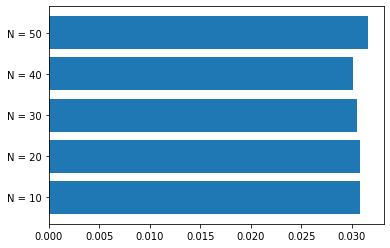

In [90]:
plt.barh(['N = 10','N = 20','N = 30','N = 40','N = 50'],precisions, label = 'Precision')
plt.show()

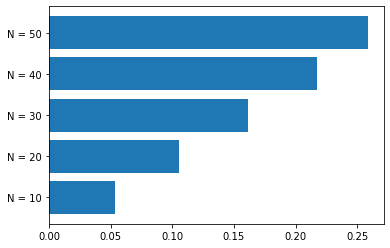

In [91]:
plt.barh(['N = 10','N = 20','N = 30','N = 40','N = 50'], recalls, label = 'recall')
plt.show()

In [62]:
def predict(model, test_features, test_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """

    #compute accuracy
    test_preds=model.predict(test_features)

    print(collections.Counter(np.array(test_preds)))
    acc=accuracy_score(test_labels,test_preds)
    recall=recall_score(test_labels,test_preds)
    precision=precision_score(test_labels,test_preds)

    print('Accuracy:',acc, 'Recall:',recall, 'Precision:',precision)
    return test_preds

In [63]:
test_neg_edges = get_neg_edges_bipartite(G_test)
# --- Create feature vector for all edges in training set and test set ---
test_features = feature_extractor(G_test, test_neg_edges)

100%|██████████| 76065/76065 [00:13<00:00, 5674.34it/s]


In [64]:
test_labels = get_edges_values(G_test_gt, test_neg_edges)

In [65]:
preds = predict(model,test_features,test_labels)

Counter({0: 74901, 1: 1164})
Accuracy: 0.976835601130612 Recall: 0.02689873417721519 Precision: 0.014604810996563574
